In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
review_dict = {}
df_review = pd.read_csv("IMDB Dataset.csv")
df_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df_review.shape

(50000, 2)

In [4]:
df_positive = df_review[df_review['sentiment']=='positive'][:5000]
df_negative = df_review[df_review['sentiment']=='negative'][:5000]

df = pd.concat([df_positive,df_negative ])

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['sentiment'])

LabelEncoder()

In [6]:
le.classes_

array(['negative', 'positive'], dtype=object)

In [7]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size =0.33,random_state=42)

In [8]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)


In [10]:
transformed_train_y = le.transform(train_y)
transformed_test_y = le.transform(test_y)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [12]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

# Create a pipeline
pipe = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

In [13]:
# # Candidate learning algorithms and their hyperparameters
search_space = [
# {'clf': [DecisionTreeClassifier()],  # Actual Estimator
#                  'clf__criterion': ['gini', 'entropy'],
#                  'clf__max_depth' : [None,5,10],
#                  'clf__max_leaf_nodes' : [None,2,4,8],},
                
                {'clf': [SVC()],
                    'clf__C': [4],
                    'clf__break_ties': [False],
                    'clf__cache_size': [200],
                    'clf__class_weight': [None],
                    'clf__coef0': [0.0],
                    'clf__decision_function_shape': ['ovr'],
                    'clf__degree': [3],
                    'clf__gamma': ['scale'],
                    'clf__kernel': ['rbf'],
                    'clf__max_iter': [-1],
                    'clf__probability': [False],
                    'clf__random_state': [None],
                    'clf__shrinking': [True],
                    'clf__tol': [0.001],
                    'clf__verbose': [False]}
               ]

In [14]:
# Create grid search 
gs = GridSearchCV(pipe, search_space)

In [15]:
gs.fit(train_x_vector, transformed_train_y)

GridSearchCV(estimator=Pipeline(steps=[('clf', DummyEstimator())]),
             param_grid=[{'clf': [SVC(C=4)], 'clf__C': [4],
                          'clf__break_ties': [False], 'clf__cache_size': [200],
                          'clf__class_weight': [None], 'clf__coef0': [0.0],
                          'clf__decision_function_shape': ['ovr'],
                          'clf__degree': [3], 'clf__gamma': ['scale'],
                          'clf__kernel': ['rbf'], 'clf__max_iter': [-1],
                          'clf__probability': [False],
                          'clf__random_state': [None], 'clf__shrinking': [True],
                          'clf__tol': [0.001], 'clf__verbose': [False]}])

In [16]:
gs.best_params_

{'clf': SVC(C=4),
 'clf__C': 4,
 'clf__break_ties': False,
 'clf__cache_size': 200,
 'clf__class_weight': None,
 'clf__coef0': 0.0,
 'clf__decision_function_shape': 'ovr',
 'clf__degree': 3,
 'clf__gamma': 'scale',
 'clf__kernel': 'rbf',
 'clf__max_iter': -1,
 'clf__probability': False,
 'clf__random_state': None,
 'clf__shrinking': True,
 'clf__tol': 0.001,
 'clf__verbose': False}

In [17]:
best_estimator = gs.best_estimator_

In [18]:
from sklearn.metrics import f1_score, accuracy_score, log_loss, roc_auc_score

In [19]:
y_pred = best_estimator.predict(test_x_vector)

In [20]:
f1_score(transformed_test_y,y_pred)


0.875998816217816

In [21]:
accuracy_score(transformed_test_y,y_pred)

0.873030303030303

In [22]:
log_loss(transformed_test_y,y_pred)

4.5764517484969955

In [23]:
roc_auc_score(transformed_test_y,y_pred)

0.8728754212415991

In [24]:
le.inverse_transform(best_estimator.predict(tfidf.transform(["Its such a beautiful day."])))[0]

'positive'

In [25]:
from joblib import dump
dump(best_estimator, 'best_estimator')

['best_estimator']

In [26]:
from joblib import load
classifier = load('best_estimator')

In [27]:
classifier.get_params()

{'memory': None,
 'steps': [('clf', SVC(C=4))],
 'verbose': False,
 'clf': SVC(C=4),
 'clf__C': 4,
 'clf__break_ties': False,
 'clf__cache_size': 200,
 'clf__class_weight': None,
 'clf__coef0': 0.0,
 'clf__decision_function_shape': 'ovr',
 'clf__degree': 3,
 'clf__gamma': 'scale',
 'clf__kernel': 'rbf',
 'clf__max_iter': -1,
 'clf__probability': False,
 'clf__random_state': None,
 'clf__shrinking': True,
 'clf__tol': 0.001,
 'clf__verbose': False}

In [28]:
import requests
from bs4 import BeautifulSoup
def fetch_all_movie_names():
   
    imdb_url = "https://www.imdb.com/list/ls565461384/"
    response = requests.get(imdb_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all the movie titles and links
        movies = soup.find_all('h3', class_='lister-item-header')

        # Extract and print the titles and links
        for movie in movies:
            title = movie.a.text
            link = "https://www.imdb.com" + movie.a['href'] + 'reviews/'
            review_dict.update({
                title:link
            })

        #movie_list.delete(0, tk.END)  # Clear the current movie list
        for movie_name in review_dict.keys():
            print(movie_name)



fetch_all_movie_names()

Jawan
Pathaan
Dunki
Animal
Tiger 3
Sam Bahadur
Leo
12th Fail
Chhatriwali
OMG 2
Bheed
Bad Boy
Music School
Tu Jhoothi Main Makkaar
Bholaa
Satyaprem Ki Katha
Zara Hatke Zara Bachke
Mission Raniganj: The Great Bharat Rescue
Sirf Ek Bandaa Kaafi Hai
Jogira Sara Ra Ra
Gulmohar
Gandhi Godse Ek Yudh
Mrs. Chatterjee vs. Norway
IB 71
Rocky Aur Rani Kii Prem Kahaani
Bloody Daddy
Mission Majnu
Ponniyin Selvan: Part Two
Jailer
Bawaal
The Archies
Salaar: Cease Fire - Part 1
Yaariyan 2


In [32]:
movie_name=input("Enter any movie")


In [33]:
url = review_dict[movie_name]
link_url = review_dict[movie_name]+'_ajax/'
print(url, link_url)

https://www.imdb.com/title/tt13751694/reviews/ https://www.imdb.com/title/tt13751694/reviews/_ajax/


In [34]:
reviews = []



##start_url = 'https://www.imdb.com/title/tt13751694/reviews?ref_=tt_urv'
#link = 'https://www.imdb.com/title/tt13751694/reviews/_ajax'

start_url = review_dict[movie_name]
link = review_dict[movie_name]+'/_ajax'
params = {
    'ref_': 'undefined',
    'paginationKey': ''
}

with requests.Session() as s:
    s.headers['User-Agent'] = 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'
    res = s.get(start_url)

    while True:
        soup = BeautifulSoup(res.text,"lxml")
        for item in soup.select(".review-container"):
            reviewer_name = item.select_one("span.display-name-link > a").get_text(strip=True)
            review_content = item.select_one("div.text.show-more__control").get_text(strip=True)
            review_date = item.select_one("span.review-date").get_text(strip=True)
            
            reviews.append({
                "review":review_content,
                "date":review_date
            })
#             print(f"Reviewer: {reviewer_name}")
#             print("Review:")
#             print(review_content)
#             print("="*40)  # Separating line

        try:
            pagination_key = soup.select_one(".load-more-data[data-key]").get("data-key")
        except AttributeError:
            break
        params['paginationKey'] = pagination_key
        res = s.get(link,params=params)



movie_review_df = pd.DataFrame(reviews)
movie_review_df['date'] = pd.to_datetime(movie_review_df['date'])   
movie_review_df.sort_values(by='date',inplace=True,ignore_index=True)
movie_review_df

,review,date
0,"What an experience man, what a writing. Anyone...",2023-12-01
1,"First few mins of the movie are good, but then...",2023-12-01
2,"Amazing direction, capable of keeping veiwers ...",2023-12-01
3,"The first half is fine, story is somewhat enga...",2023-12-01
4,Perhaps the best movie of 2023 coming from bol...,2023-12-01
...,...,...
568,I'm thrilled to share my admiration for Ranbir...,2023-12-09
569,"I see lot of negative reviews for animal, and ...",2023-12-09
570,"First and foremost, even if there is 1% chance...",2023-12-09
571,One who will watch this movie is going to have...,2023-12-09


In [ ]:
vectorize_reviews = tfidf.transform(movie_review_df['review'])
prediction = classifier.predict(vectorize_reviews)
movie_review_df['Prediction'] = le.inverse_transform(prediction)

In [ ]:
movie_review_df

,review,date,Prediction
0,The central plot of the movie follows a somewh...,2023-10-18,positive
1,Leo is an absolute masterpiece in Tamil cinema...,2023-10-18,positive
2,One of best Direction. Indian cinema next leve...,2023-10-18,positive
3,"On the bright side, we get..One of Vijay's fin...",2023-10-19,positive
4,"Leo= sura, kuruvi, beast\nIt's over hyped movi...",2023-10-19,positive
...,...,...,...
371,Fantastic how the hero can exit a head on cras...,2023-12-03,negative
372,Overall the Film Is great and well directed bo...,2023-12-03,positive
373,The initial half of the film captivates viewer...,2023-12-04,positive
374,First Half - 10\nSecond Half - 7\nAction - 10\...,2023-12-04,positive


In [ ]:
sum_ = []
cnt = 0
for i in prediction:
    f = lambda x: -1 if x == 0 else 1
    cnt += f(i)
    sum_.append(cnt)

In [ ]:
movie_review_df['Popularity'] = sum_


In [ ]:
movie_review_df

,review,date,Prediction,Popularity
0,The central plot of the movie follows a somewh...,2023-10-18,positive,1
1,Leo is an absolute masterpiece in Tamil cinema...,2023-10-18,positive,2
2,One of best Direction. Indian cinema next leve...,2023-10-18,positive,3
3,"On the bright side, we get..One of Vijay's fin...",2023-10-19,positive,4
4,"Leo= sura, kuruvi, beast\nIt's over hyped movi...",2023-10-19,positive,5
...,...,...,...,...
371,Fantastic how the hero can exit a head on cras...,2023-12-03,negative,194
372,Overall the Film Is great and well directed bo...,2023-12-03,positive,195
373,The initial half of the film captivates viewer...,2023-12-04,positive,196
374,First Half - 10\nSecond Half - 7\nAction - 10\...,2023-12-04,positive,197


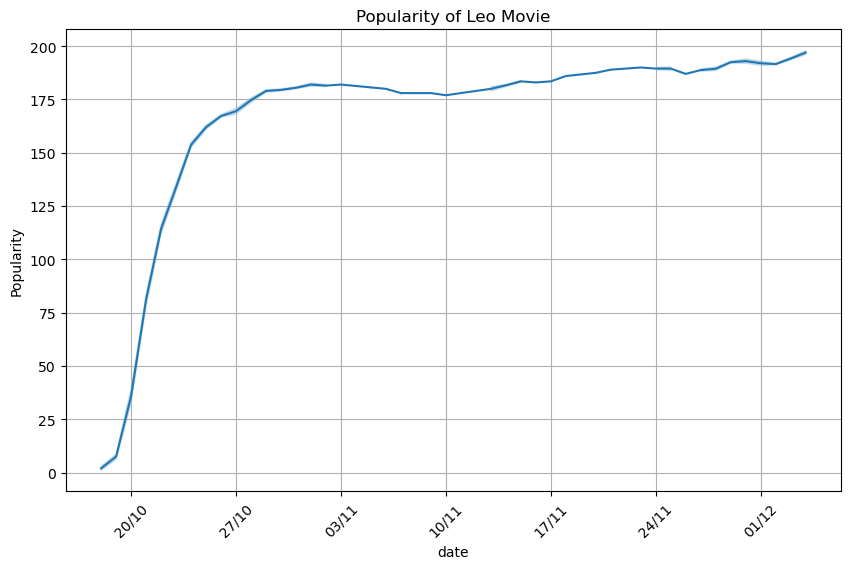

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))  # set the size of the figure
sns.lineplot(x='date', y='Popularity', data=movie_review_df)

# Formatting the x-axis to show dates in the format "YYYY-MM-DD"
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

# Display the grid
ax.grid(True)

plt.title("Popularity of "+ movie_name +" Movie")
plt.show()

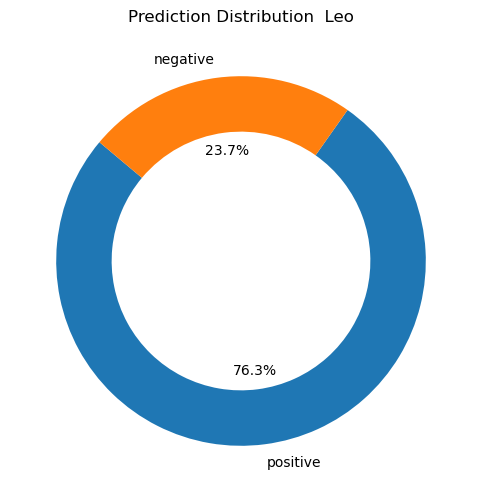

In [ ]:
# Calculate the frequency of each unique value in the "Prediction" column
prediction_counts = movie_review_df['Prediction'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Prediction Distribution  '+movie_name)
plt.show()

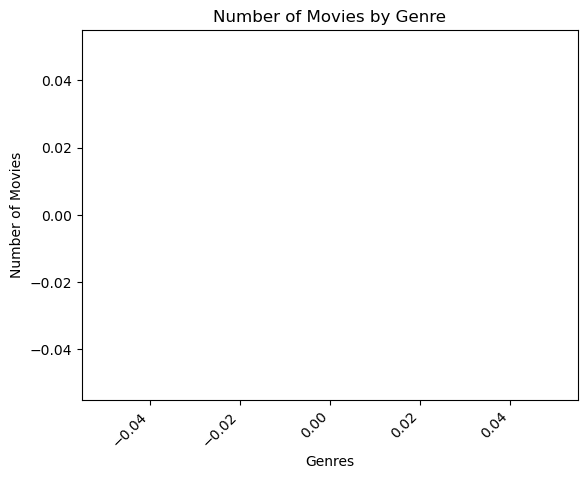

In [ ]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

def fetch_movie_genres(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        movie_elements = soup.find_all("div", class_="lister-item-content")

        genres = []

        for movie_element in movie_elements:
            genre_elements = movie_element.find_all("span", class_="genre")
            for genre_element in genre_elements:
                genre = genre_element.get_text(strip=True)
                genres.extend(genre.split(','))

        return genres

    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)
        return []

def plot_genre_bar_graph(genres):
    genre_counts = {genre: genres.count(genre) for genre in set(genres)}

    plt.bar(genre_counts.keys(), genre_counts.values())
    plt.xlabel('Genres')
    plt.ylabel('Number of Movies')
    plt.title('Number of Movies by Genre')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# IMDb search URL for Hindi language movies released in 2023
imdb_url = "https://www.imdb.com/search/title/?languages=hi&year=2023,2023"

# Fetch movie genres from the IMDb search URL
movie_genres = fetch_movie_genres(imdb_url)

# Plot the bar graph
plot_genre_bar_graph(movie_genres)

    